# Build a transient version of the Freyberg model from the existing model files

In this notebook, we will use flopy to construct a time-varying history simulation with the existing Freyberg model files.  Hang on tight!

In [32]:
%matplotlib inline
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu
import prep_deps
import redis
import matplotlib as mpl
plt.rcParams['font.size']=12

This the location and nam file of the existing model

In [33]:
org_d = os.path.join("..","base_model_files")
org_nam = "freyberg.nam"

Load the existing model into a flopy `Modflow` model instance and plot

In [34]:
m_org = flopy.modflow.Modflow.load(org_nam,model_ws=org_d,check=False)
m_org

MODFLOW 3 layer(s) 40 row(s) 20 column(s) 2 stress period(s)

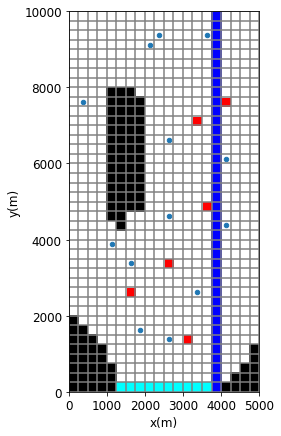

In [35]:
# plot some model attributes
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111,aspect="equal")
mm = flopy.plot.PlotMapView(model=m_org)
mm.plot_grid()
mm.plot_ibound()
mm.plot_bc('SFR')
mm.plot_bc("GHB")
ax = mm.ax
#m.wel.stress_period_data.plot(ax=ax,mflay=2)

# plot obs locations
obs = pd.read_csv(os.path.join("..","base_model_files","obs_loc.csv"))
                  
obs_x = [m_org.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
obs_y = [m_org.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
ax.scatter(obs_x,obs_y,marker='.',label="water-level obs",s=80)

#plot names on the pumping well locations
wel_data = m_org.wel.stress_period_data[0]
wel_x = m_org.sr.xcentergrid[wel_data["i"],wel_data["j"]]
wel_y = m_org.sr.ycentergrid[wel_data["i"],wel_data["j"]]
for i,(x,y) in enumerate(zip(wel_x,wel_y)):
    ax.scatter([x],[y],color="red",marker="s",s=50)
    #ax.text(x,y,"{0}".format(i+1),ha="center",va="center")

ax.set_ylabel("y(m)")
ax.set_xlabel("x(m)")
plt.show()

`tr_d` is the `d`irectory where we are going to write out the `tr`ansient model

In [36]:
tr_d = "temp_history"
tr_nam = "freyberg"

Create the new model instance

In [37]:
m_tr = flopy.modflow.Modflow(tr_nam,model_ws=tr_d,version="mfnwt")

Now we need to build up the time-stepping containers.  We will use 1 initial steady-state stress period then 24 monthly stress period thereafter. We will use some pandas time series handling - ah yeah!

In [38]:
tr_nper = 24 #num transient stress periods
freq = "m" #monthly frequency

First, `flopy` will need a list of `True` or `False` flags indicating whether each stress period is steady state or not

In [39]:
steady = [True]
for _ in range(tr_nper):
    steady.append(False)
steady

[True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

Next set up the period lengths in `perlen` based on the 24 months after the starting date

In [40]:
start_datetime = "12-31-2015"
end = pd.date_range(start=start_datetime,periods=tr_nper+1,freq=freq)
delt = end[1:] - end[:-1]
perlen = list(delt.days.values)
perlen.insert(0,1)
print(end) # the pandas datetime index of the ending date of each stress period
print(perlen) # the length in days of each stress period
model_start_datetime = "12-31-2015"
assert len(perlen) == tr_nper + 1,len(perlen)

DatetimeIndex(['2015-12-31', '2016-01-31', '2016-02-29', '2016-03-31',
               '2016-04-30', '2016-05-31', '2016-06-30', '2016-07-31',
               '2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30',
               '2016-12-31', '2017-01-31', '2017-02-28', '2017-03-31',
               '2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31',
               '2017-08-31', '2017-09-30', '2017-10-31', '2017-11-30',
               '2017-12-31'],
              dtype='datetime64[ns]', freq='M')
[1, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]


Now we can create a `Dis` package.  We will reuse a lot of attributes from the existing model except for the time-stepping info:

In [41]:
_ = flopy.modflow.ModflowDis(m_tr,nper=tr_nper+1,nlay=m_org.nlay,
                             nrow=m_org.nrow,ncol=m_org.ncol,
                             delr=m_org.dis.delr.array,delc=m_org.dis.delc.array,
                             top=m_org.dis.top.array,botm=m_org.dis.botm.array,
                             steady=steady,
                             perlen=perlen)
m_tr.dis.start_datetime = model_start_datetime

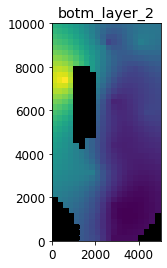

In [42]:
m_org.dis.botm[2].plot()

The `BAS`ic package and the `UPW` are taken directly from the existing model:

In [43]:
_ = flopy.modflow.ModflowBas(m_tr,ibound=m_org.bas6.ibound.array,
                             strt=m_org.bas6.strt.array,hnoflo=m_org.bas6.hnoflo)

In [44]:
_ = flopy.modflow.ModflowUpw(m_tr,ipakcb=50,laytyp=[1,0,0],hk=m_org.upw.hk.array,
                             vka=m_org.upw.vka.array,ss=m_org.upw.ss.array,sy=m_org.upw.sy.array)

Now for solver and output control

In [45]:
_ = flopy.modflow.ModflowNwt(m_tr,headtol=0.01,fluxtol=1.0)
_ = flopy.modflow.ModflowOc(m_tr,stress_period_data={
                (kper,0):["save head","save budget"] for kper in range(m_tr.nper)})

To make things more fun, we are going to apply time-varying forcing conditions for `RECH`arge, `WEL`, and `SFR` inflow.  Let's use the classic - the sine wave

We will create a multiplier that varies seasonally by the sine wave and we will use to adjust the recharge, inflow, and pumping from the original Freyberg steady-state model.

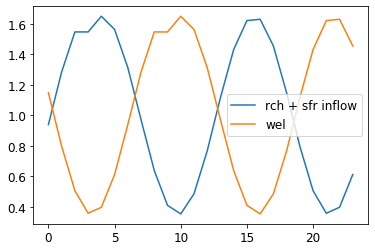

In [48]:
angles = np.linspace(-np.pi, np.pi, tr_nper)
season_mults = 1.0 + 0.65*np.sin(1 + angles*2)
season_mults = np.roll(season_mults,int(tr_nper / 8))
wel_season_mults = np.roll(season_mults,int(tr_nper / 4))
plt.plot(np.arange(tr_nper),season_mults, label="rch + sfr inflow")
plt.plot(np.arange(tr_nper),wel_season_mults, label="wel")
plt.legend()

So you can see we have pushed the wel flux to be out of phase with recharge and `SFR` inflow - should make things more interesting...

Now let's build up the `WEL` and `RCH` package info:

In [16]:
org_wel_data = m_org.wel.stress_period_data[0]
org_rch = m_org.rch.rech[0].array
wel_data = {0:org_wel_data}
rech = {0:org_rch}
for kper in range(1,m_tr.nper):
    kper_wel_data = org_wel_data.copy()
    kper_wel_data["flux"] *= wel_season_mults[kper-1]
    wel_data[kper] = kper_wel_data
    rech[kper] = org_rch * season_mults[kper-1]

Make a `WEL` and `RCH` packages

In [17]:
_ = flopy.modflow.ModflowWel(m_tr,stress_period_data=wel_data,ipakcb=50)

In [18]:
_ = flopy.modflow.ModflowRch(m_tr,rech=rech,ipakcb=50)

Just use the same drain as before

In [19]:
_ = flopy.modflow.ModflowGhb(m_tr,stress_period_data=m_org.ghb.stress_period_data,ipakcb=50)

Now for everyone's fav, `SFR` - sigh.  So, as usual, it takes special handling....

In [20]:
m_org.sfr.reach_data

rec.array([( 15, 0,  0, 15,  1, 1, 250., 34.      , 5.e-05, 1., 0.1, 0., 0., 0., 0.,  1,  2),
           ( 35, 0,  1, 15,  2, 1, 250., 33.98718 , 5.e-05, 1., 0.1, 0., 0., 0., 0.,  2,  3),
           ( 55, 0,  2, 15,  3, 1, 250., 33.974358, 5.e-05, 1., 0.1, 0., 0., 0., 0.,  3,  4),
           ( 75, 0,  3, 15,  4, 1, 250., 33.96154 , 5.e-05, 1., 0.1, 0., 0., 0., 0.,  4,  5),
           ( 95, 0,  4, 15,  5, 1, 250., 33.94872 , 5.e-05, 1., 0.1, 0., 0., 0., 0.,  5,  6),
           (115, 0,  5, 15,  6, 1, 250., 33.935898, 5.e-05, 1., 0.1, 0., 0., 0., 0.,  6,  7),
           (135, 0,  6, 15,  7, 1, 250., 33.923077, 5.e-05, 1., 0.1, 0., 0., 0., 0.,  7,  8),
           (155, 0,  7, 15,  8, 1, 250., 33.910255, 5.e-05, 1., 0.1, 0., 0., 0., 0.,  8,  9),
           (175, 0,  8, 15,  9, 1, 250., 33.897434, 5.e-05, 1., 0.1, 0., 0., 0., 0.,  9, 10),
           (195, 0,  9, 15, 10, 1, 250., 33.884617, 5.e-05, 1., 0.1, 0., 0., 0., 0., 10, 11),
           (215, 0, 10, 15, 11, 1, 250., 33.871796, 5.e-05, 

In [21]:
# get the org seg and reach data
rdata = pd.DataFrame.from_records(m_org.sfr.reach_data)
sdata = pd.DataFrame.from_records(m_org.sfr.segment_data[0])
rdata = rdata.reindex(np.arange(m_tr.nrow))

# define the upstream and downstream channel bottoms
# and workout the slope
upstrm = 34
dwstrm = 33.5
total_length = m_tr.dis.delc.array.max() * m_tr.nrow
slope = (upstrm - dwstrm) / total_length
strtop = np.linspace(upstrm, dwstrm, m_tr.nrow)
rdata.loc[:,"strtop"] = strtop
rdata.loc[:,"slope"] = slope

# now for the seg data
sdata = sdata.reindex(np.arange(m_tr.nrow))
for column in sdata.columns:
    sdata.loc[:,column] = sdata.loc[0,column]
sdata.loc[:,"nseg"] = np.arange(m_tr.nrow) + 1
sdata.loc[1:,"flow"] = 0
sdata.loc[:,"width1"] = 5.
sdata.loc[:,"width2"] = 5.
sdata.loc[:,"elevup"] = strtop
sdata.loc[:,"elevdn"] = strtop - slope
sdata.loc[:,"outseg"] = sdata.nseg + 1
sdata.loc[m_tr.nrow-1,"outseg"] = 0

# now for the time-varying inflow mults
sdata_dict = {0:sdata.to_records(index=False)}
for kper in range(1,m_tr.nper):
    kper_sdata = sdata.to_records(index=False)
    kper_sdata["flow"] *= season_mults[kper-1]
    sdata_dict[kper] = kper_sdata

# and now for a new SFR package
_ = flopy.modflow.ModflowSfr2(m_tr,nstrm=m_tr.nrow,nss=m_tr.nrow,isfropt=m_org.sfr.isfropt,
                          segment_data=sdata_dict,
                          reach_data=rdata.to_records(index=False),ipakcb=m_org.sfr.ipakcb,
                          istcb2=m_org.sfr.istcb2,reachinput=True)

Write the model inputs

In [22]:
m_tr.write_input()

This little helper function just copies the current OS binaries into the `tr_d` directory so that MODFLOW will actually run - useful!

In [23]:
prep_deps.prep_template(tr_d)

Now we run the model - let's use the pyemu run helper since it handles OS-specific issues (like appending ".exe" or prepending "./" if needed)

In [24]:
pyemu.os_utils.run("mfnwt {0}".format(tr_nam),cwd=tr_d)

So let's post-process the run and make sure everything is cool

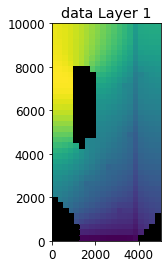

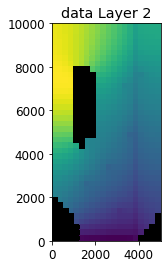

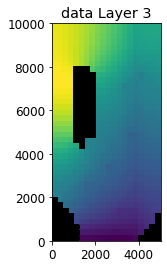

In [25]:
hds = flopy.utils.HeadFile(os.path.join(tr_d,tr_nam+".hds"), model=m_tr)
hds.plot()

In [26]:
lst = flopy.utils.MfListBudget(os.path.join(tr_d,tr_nam+".list"))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa1784088d0>,
      dtype=object)

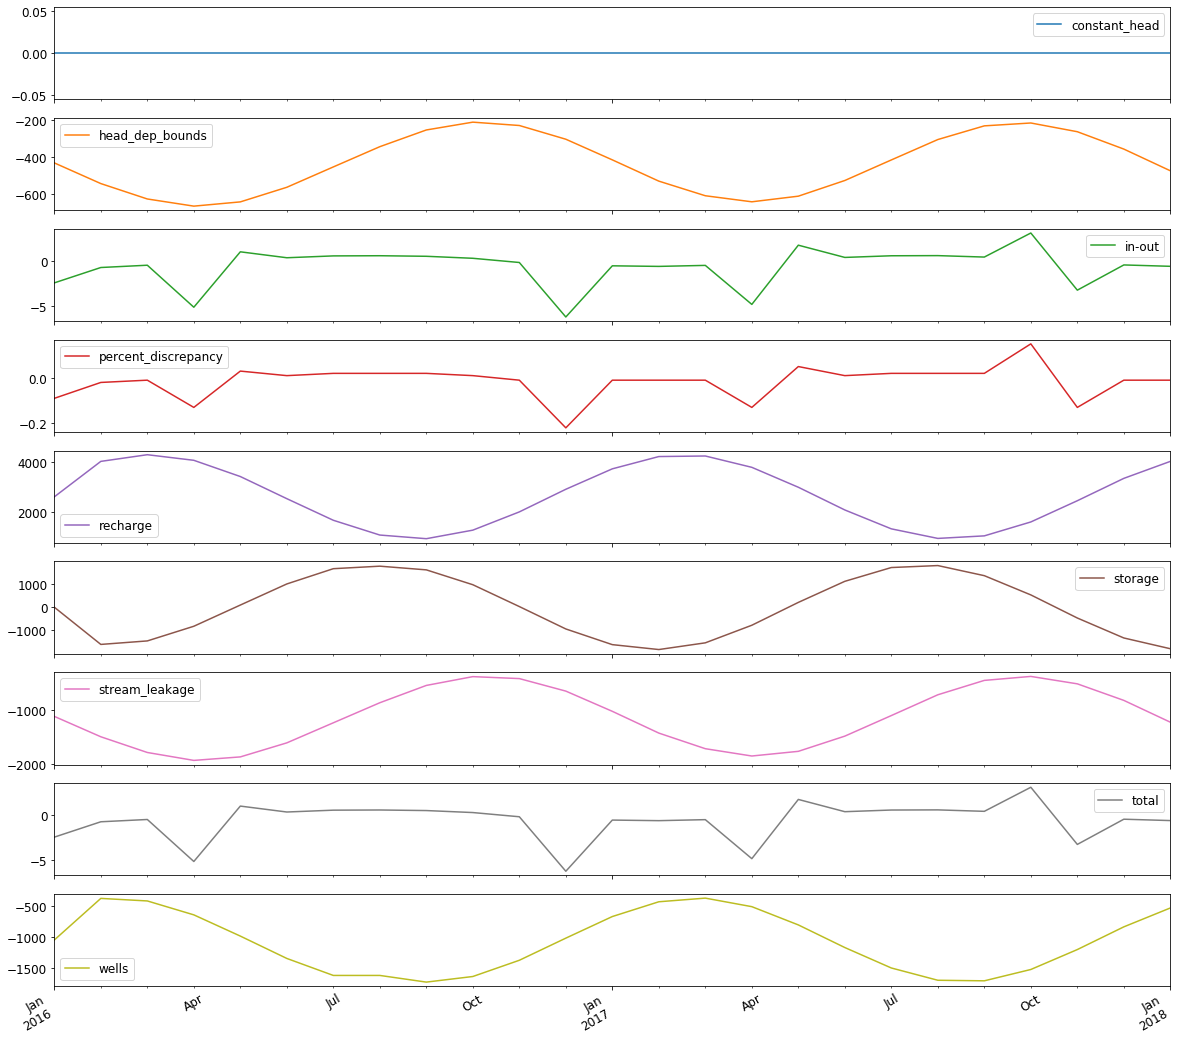

In [27]:
flx,vol = lst.get_dataframes(diff=True,start_datetime=m_tr.start_datetime)
flx.plot(subplots=True,figsize=(20,20))

Important take away: notice how the stream leakage flux is out of phase with both `WEL` and `RCH`  - this should make for some interesting results later!

Now we need to get the MODPATH files into the `tr_d` directory for later:

In [28]:
mp_files = [f for f in os.listdir(org_d) if "mp" in f or "location" in f]
[shutil.copy2(os.path.join(org_d,f),os.path.join(tr_d)) for f in mp_files]

['temp_history/freyberg.mpenpt',
 'temp_history/mp_ibound_1.ref',
 'temp_history/mp_ibound_2.ref',
 'temp_history/mp_ibound_3.ref',
 'temp_history/freyberg.mppthln',
 'temp_history/freyberg.locations',
 'temp_history/freyberg.mpsim',
 'temp_history/freyberg.mplist',
 'temp_history/freyberg.mpbas',
 'temp_history/freyberg.mpnam']

Let's write some generic porosity arrays and make sure MODPATH runs:

In [29]:
for k in range(m_tr.nlay):
    np.savetxt(os.path.join(tr_d,"prsity_layer_{0}.ref".format(k+1)),np.zeros((m_tr.nrow,m_tr.ncol))+0.0005,fmt="%15.6E")

In [30]:
pyemu.os_utils.run("mp6 freyberg.mpsim",cwd=tr_d)

In [31]:
[print (i.rstrip()) for i in open("temp_history/freyberg.mpenpt",'r').readlines()]

MODPATH_ENDPOINT_FILE 6 0
 1          1          1          1   0.0000000E+00
         0          0          1          0          0          0
         1
part
END HEADER
          1     1  2   0.0000000E+00   0.7198692E+03  1    1   15    3 6          1   0.5000000E+00   0.5000000E+00   0.1000000E+01   0.6250000E+03   0.6375000E+04   0.3475671E+02  1    3   35   13 4          1   0.7687384E+00   0.1000000E+01   0.4072336E-01   0.3192185E+04   0.1500000E+04   0.1459021E+01 part_0000


[None, None, None, None, None, None, None]